In [1]:
import torch
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
from plantcv import plantcv as pcv

from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
folder_path

In [2]:
torch.cuda.empty_cache()

In [3]:
torch.set_default_dtype(torch.float32)

In [4]:
device = torch.device("cuda:0")
torch.set_default_device(device)

#torch.cuda.set_per_process_memory_fraction(0.5, device=device)

print(torch.cuda.get_device_properties(device).multi_processor_count)
torch.cuda.memory_allocated(device=torch.device("cuda"))
torch.cuda.memory_summary(device=torch.device("cuda"), abbreviated=False)

36


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [5]:
transform = transforms.ToTensor()

In [6]:
class CustomSegmentationDatasetCup(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.image_paths))
        
    def __getitem__(self, idx):
        image_path = os.listdir(self.image_paths)[idx]
        label_path = os.listdir(self.label_paths)[idx]
        
        image = Image.open(self.image_paths + "\/" + image_path)
        image = image.convert('L')
        
        cup_label = loadmat(self.label_paths + "\/" +label_path).get('mask')
        
        cup_label[cup_label ==1] = 0
        cup_label[cup_label == 2] = 255
        
        # cup_label = crop_image(np.array(cup_label), 20, 40)
        #cup_label = create_multichannel_mask(cup_label)
        
        if self.transform:
            image = self.transform(image)#.to(device)
            cup_label = Image.fromarray(cup_label)

            cup_label = self.transform(cup_label)
            cup_label = cup_label.to(torch.float)
        # label = torch.from_numpy(label)
        # label = label.to(torch.long)#.to(device)
        #combined_labels_tensor = torch.stack([disk_label, cup_label], dim=1)
        
        return image, cup_label

In [7]:
class CustomSegmentationDatasetDisk(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image_path = os.listdir(self.image_paths)[idx]
        label_path = os.listdir(self.label_paths)[idx]
        
        image = Image.open(self.image_paths + "\/" + image_path)
        image = image.convert('L')
        
        disk_label = loadmat(self.label_paths + "\/" +label_path).get('mask')
        disk_label[disk_label == 2] = 255
        
        # disk_label = crop_image(np.array(disk_label), 20, 40)
        #disk_label = create_multichannel_mask(disk_label)
        if self.transform:
            image = self.transform(image)#.to(device)

            disk_label = Image.fromarray(disk_label)
            
            disk_label = self.transform(disk_label)
            disk_label = disk_label.to(torch.float)

        # label = torch.from_numpy(label)
        # label = label.to(torch.long)#.to(device)
        #combined_labels_tensor = torch.stack([disk_label, cup_label], dim=1)
        return image, disk_label

In [8]:

data_transform = transforms.Compose([
    #transform.Lambda(to_grayscale_pil),
    transforms.Resize((512, 512), antialias=True),
    transforms.ToTensor(),
])

In [9]:
train_dataset_disk = CustomSegmentationDatasetDisk(r''+folder_path+r'\Datasets\ORIGA\ImagesCropped\Train', r''+folder_path+r'\Datasets\ORIGA\LabelsCropped\Train', data_transform)
valid_dataset_disk = CustomSegmentationDatasetDisk(r''+folder_path+r'\Datasets\ORIGA\ImagesCropped\Valid', r''+folder_path+r'\Datasets\ORIGA\LabelsCropped\Valid', data_transform)

In [10]:
train_dataset_cup = CustomSegmentationDatasetCup(r''+folder_path+r'\Datasets\ORIGA\ImagesCropped\Train', r''+folder_path+r'\Datasets\ORIGA\LabelsCropped\Train', data_transform)
valid_dataset_cup = CustomSegmentationDatasetCup(r''+folder_path+r'\Datasets\ORIGA\ImagesCropped\Valid', r''+folder_path+r'\Datasets\ORIGA\LabelsCropped\Valid', data_transform)

In [11]:
batchSize = 64
train_data_disk = torch.utils.data.DataLoader(train_dataset_disk, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)
valid_data_disk = torch.utils.data.DataLoader(valid_dataset_disk, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)

train_data_cup = torch.utils.data.DataLoader(train_dataset_cup, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)
valid_data_cup = torch.utils.data.DataLoader(valid_dataset_cup, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)

In [12]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_planes),)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [13]:
class Encoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(Encoder, self).__init__()
        self.block1 = BasicBlock(in_planes, out_planes, kernel_size, stride, padding, groups, bias)
        self.block2 = BasicBlock(out_planes, out_planes, kernel_size, 1, padding, groups, bias)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x


In [14]:
class Decoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        # TODO bias=True
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, in_planes//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_planes//4, in_planes//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes//4, out_planes, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_planes),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x

In [15]:
class LinkNetBase(nn.Module):
    """
    Generate model architecture
    """

    def __init__(self, n_classes=1, num_channels = 1):
        """
        Model initialization
        :param x_n: number of input neurons
        :type x_n: int
        """
        super(LinkNetBase, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.encoder1 = Encoder(64, 64, 3, 1, 1)
        self.encoder2 = Encoder(64, 128, 3, 2, 1)
        self.encoder3 = Encoder(128, 256, 3, 2, 1)
        self.encoder4 = Encoder(256, 512, 3, 2, 1)
        self.encoder5 = Encoder(512, 1024, 3, 2, 1)
        
        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)
        self.decoder5 = Decoder(1024, 512, 3, 2, 1, 1)

        # Classifier
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)
        
        self.conv3 =  nn.Sequential(nn.Conv2d(16, 16, 2, 2, 0),
                                nn.BatchNorm2d(16),
                                nn.ReLU(inplace=True),)
        self.tp_conv3 = nn.ConvTranspose2d(16, n_classes, 2, 2, 0)

        
        self.lsm = nn.LogSoftmax(dim=1) #Sigmoid/SoftMax
        
        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax(dim=1)
    
    # def conv_to_match_channels(self, input_tensor, target_tensor):
    #     # Apply a convolution to match the number of channels in input_tensor with target_tensor
    #     num_channels_input = input_tensor.shape[1]
    #     num_channels_target = target_tensor.shape[1]
    
    #     if num_channels_input < num_channels_target:
    #         # Apply a convolution to increase the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     elif num_channels_input > num_channels_target:
    #         # Apply a convolution to decrease the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     else:
    #         # No need to change channels
    #         return input_tensor
    
    #     return F.relu(conv_layer(input_tensor))
            
    def forward(self, x):
        # Initial block
        # Assuming x is a tuple with (original_image, distance_transform)
        #x = torch.cat(x, dim=1) # Concatenate along the channel dimension
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Encoder blocks
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        
        # Decoder blocks
        #d4 = e3 + self.decoder4(e4)
        d5 = e4 + self.decoder5(e5)
        d4 = e3 + self.decoder4(d5)
        d3 = e2 + self.decoder3(d4)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)
        # y = self.conv3(y)
        # y = self.tp_conv3(y)
        y = self.sigm(y)
        
        return y

In [16]:
num_epochs = 15
learning_rate = 0.001
weight_decay = 0.01

In [17]:
model_cup = LinkNetBase()
model_cup.to(device)
optimizer_cup = torch.optim.Adam(model_cup.parameters(), lr=learning_rate, weight_decay=weight_decay) 
criterion = torch.nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = DiceBCELoss()
print(model_cup)

LinkNetBase(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Encoder(
    (block1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [18]:
model_disk = LinkNetBase()
model_disk.to(device)
optimizer_disk = torch.optim.Adam(model_disk.parameters(), lr=learning_rate, weight_decay=weight_decay) 
criterion = torch.nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = DiceBCELoss()
print(model_disk)

LinkNetBase(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Encoder(
    (block1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [19]:
train_loss_list = []
valid_loss_list = [] 

for epoch in range(num_epochs): 
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ') 
    train_loss = 0
    valid_loss = 0
    #Iterating over the training dataset in batches 
    model_disk.train() 
    for images, labels_disk in train_data_disk: 
        #Extracting images and target labels for the batch being iterated 
        images = images.to(device) 
        labels_disk= labels_disk.to(device) 
  
        #Calculating the model output and the cross entropy loss 
        outputs = model_disk.forward(images) 

        loss = criterion(outputs, labels_disk) 
        #Updating weights according to calculated loss 
        optimizer_disk.zero_grad() 
        loss.backward() 
        optimizer_disk.step() 
        train_loss += loss.item() 
    
    model_disk.eval()
    with torch.no_grad():
        for i, (images, labels_disk) in enumerate(valid_data_disk):
            images = images.to(device) 
            labels_disk = labels_disk.to(device)
            
            outputs = model_disk(images) 
            
            loss = criterion(outputs, labels_disk)
            #dice_coef = dice_coefficient(outputs, labels_disk)
            valid_loss += loss.item() 
            
    #Printing loss for each epoch 
    train_loss_list.append(train_loss/len(train_data_disk))
    valid_loss_list.append(valid_loss/len(valid_data_disk)) 
    print(f"Training loss = {train_loss_list[-1]} Validation loss = {valid_loss_list[-1]}") #  DICE: {dice_coef}")      

Epoch 1/15: Training loss = 0.6659073531627655 Validation loss = 0.6207297742366791
Epoch 2/15: Training loss = 0.5324516892433167 Validation loss = 0.6161693930625916
Epoch 3/15: Training loss = 0.47390151023864746 Validation loss = 0.5991172194480896
Epoch 4/15: Training loss = 0.44220054149627686 Validation loss = 0.5792312026023865
Epoch 5/15: Training loss = 0.4136335402727127 Validation loss = 0.5659242570400238
Epoch 6/15: Training loss = 0.4021373391151428 Validation loss = 0.5456066429615021
Epoch 7/15: Training loss = 0.4030880331993103 Validation loss = 0.5210350751876831
Epoch 8/15: Training loss = 0.4083710163831711 Validation loss = 0.5169386267662048
Epoch 9/15: Training loss = 0.36532481014728546 Validation loss = 0.5094575583934784
Epoch 10/15: Training loss = 0.3712758868932724 Validation loss = 0.4844609946012497
Epoch 11/15: Training loss = 0.3604622781276703 Validation loss = 0.4679905027151108
Epoch 12/15: Training loss = 0.3462268114089966 Validation loss = 0.453

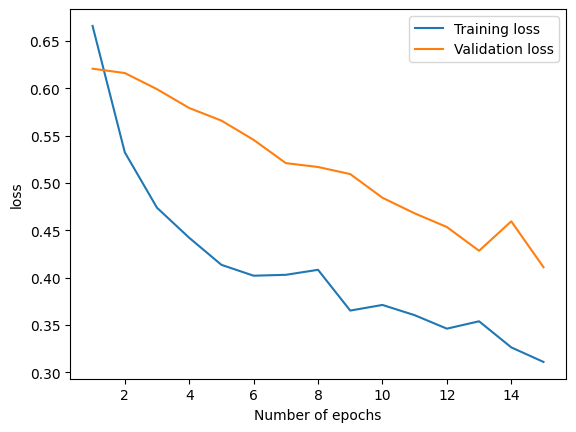

In [20]:
plt.plot(range(1,num_epochs+1), train_loss_list, label="Training loss") 
plt.plot(range(1,num_epochs+1), valid_loss_list, label="Validation loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("loss") 
plt.legend()

In [21]:
train_loss_list = []
valid_loss_list = [] 

for epoch in range(num_epochs): 
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ') 
    train_loss = 0
    valid_loss = 0
    #Iterating over the training dataset in batches 
    model_cup.train() 
    for images, labels_cup  in train_data_cup: 
        #Extracting images and target labels for the batch being iterated 
        images = images.to(device) 
        labels_cup= labels_cup.to(device) 
  
        #Calculating the model output and the cross entropy loss 
        outputs = model_cup.forward(images) 

        loss = criterion(outputs, labels_cup)
        
        #Updating weights according to calculated loss 
        optimizer_cup.zero_grad() 
        loss.backward() 
        optimizer_cup.step() 
        train_loss += loss.item() 
    
    model_cup.eval()
    with torch.no_grad():
        for i, (images, labels_cup) in enumerate(valid_data_cup):
            
            images = images.to(device) 
            labels_cup = labels_cup.to(device)
            
            outputs = model_cup(images) 
            #dice_coef = dice_coefficient(outputs, labels_cup)
            
            loss = criterion(outputs, labels_cup) 
            valid_loss += loss.item() 
    #Printing loss for each epoch 
    train_loss_list.append(train_loss/len(train_data_cup))
    valid_loss_list.append(valid_loss/len(valid_data_cup)) 
    print(f"Training loss = {train_loss_list[-1]} Validation loss = {valid_loss_list[-1]}") #  DICE: {dice_coef}")     

Epoch 1/15: Training loss = 0.5675215125083923 Validation loss = 0.6286227107048035
Epoch 2/15: Training loss = 0.4226244315505028 Validation loss = 0.5364815592765808
Epoch 3/15: Training loss = 0.36649368703365326 Validation loss = 0.44453661640485126
Epoch 4/15: Training loss = 0.33299291878938675 Validation loss = 0.40047796567281085
Epoch 5/15: Training loss = 0.30565839260816574 Validation loss = 0.37139812111854553
Epoch 6/15: Training loss = 0.2900768332183361 Validation loss = 0.3433727025985718
Epoch 7/15: Training loss = 0.27105213329195976 Validation loss = 0.3353683253129323
Epoch 8/15: Training loss = 0.25479518063366413 Validation loss = 0.36951210101445514
Epoch 9/15: Training loss = 0.25533564761281013 Validation loss = 0.42376112937927246
Epoch 10/15: Training loss = 0.23887629248201847 Validation loss = 0.37456409136454266
Epoch 11/15: Training loss = 0.2326306737959385 Validation loss = 0.3122395972410838
Epoch 12/15: Training loss = 0.2229082491248846 Validation lo

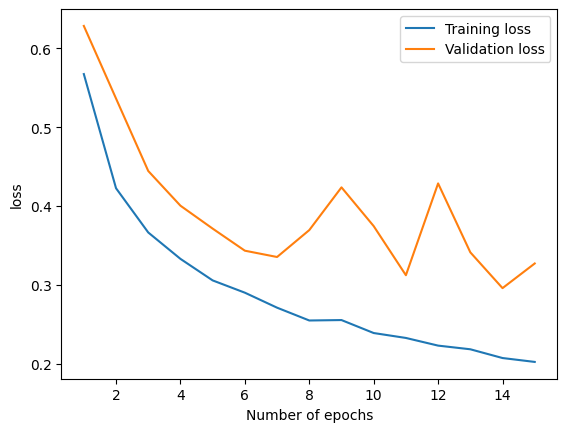

In [22]:
#plt.subplot(2, 1, 1)
plt.plot(range(1,num_epochs+1), train_loss_list, label="Training loss") 
plt.plot(range(1,num_epochs+1), valid_loss_list, label="Validation loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("loss") 
plt.legend()

In [23]:
folder = r''+folder_path+r'\Datasets\ORIGA'

test_folder = folder + '\Test'
test_gt_folder = folder + '\Test_gt'
test_results_folder = folder + '\Test_results'
test_results_disk_folder = folder + '\Test_results_disk'
test_results_cup_folder = folder + '\Test_results_cup'

test_files = os.listdir(test_folder)
test_gt_files = os.listdir(test_gt_folder)

In [36]:
# #--------------------!!!!!!!!--------------------
# test_results_disk_files = os.listdir(test_results_disk_folder)
# test_results_cup_files = os.listdir(test_results_cup_folder)

In [25]:
images_test = []
for file in test_files:
    images_test.append(test_folder + "\/" + file)

In [26]:
images_test_gt = []
for file in test_gt_files:
    images_test_gt.append(test_gt_folder + "\/" + file)

In [37]:
# #--------------------!!!!!!!!--------------------
# images_test_result_disk = []
# images_test_result_cup = []
# for file in test_results_disk_files:
#     images_test_result_disk.append(test_results_disk_folder + "\/" + file)

# for file in test_results_cup_files:
#     images_test_result_cup.append(test_results_cup_folder + "\/" + file)

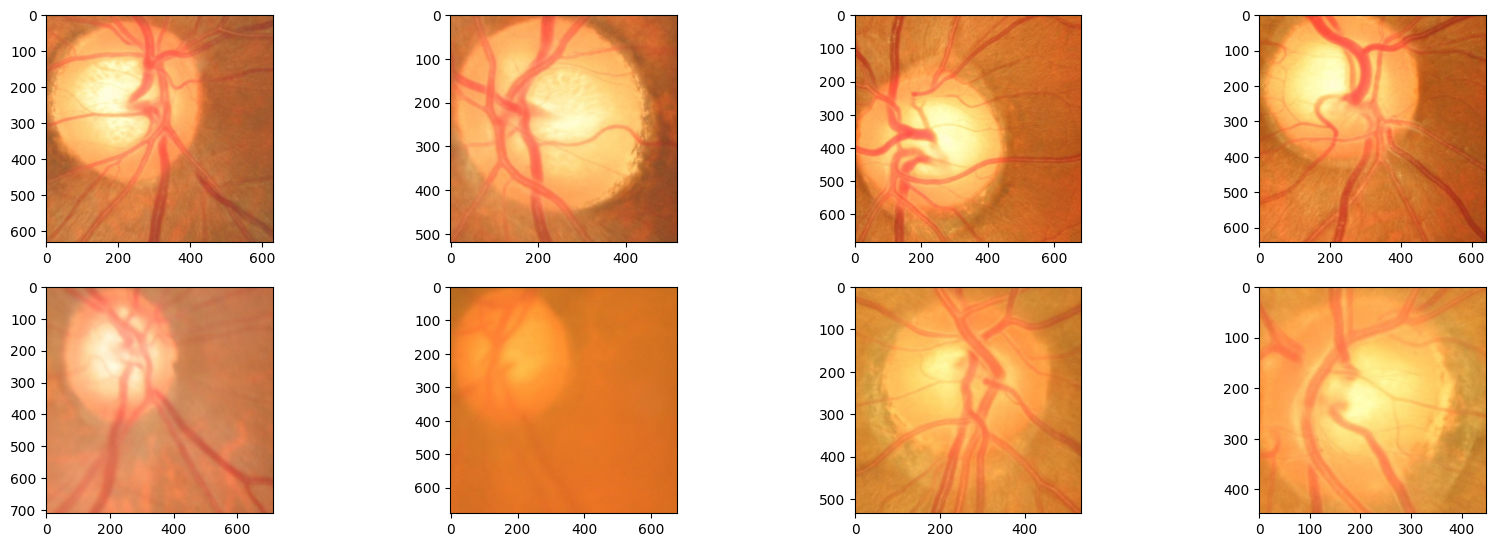

In [28]:
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(images_test):
    plt.subplot(int(len(images_test) / columns + 1), columns, i + 1)
    plt.imshow(Image.open(image))

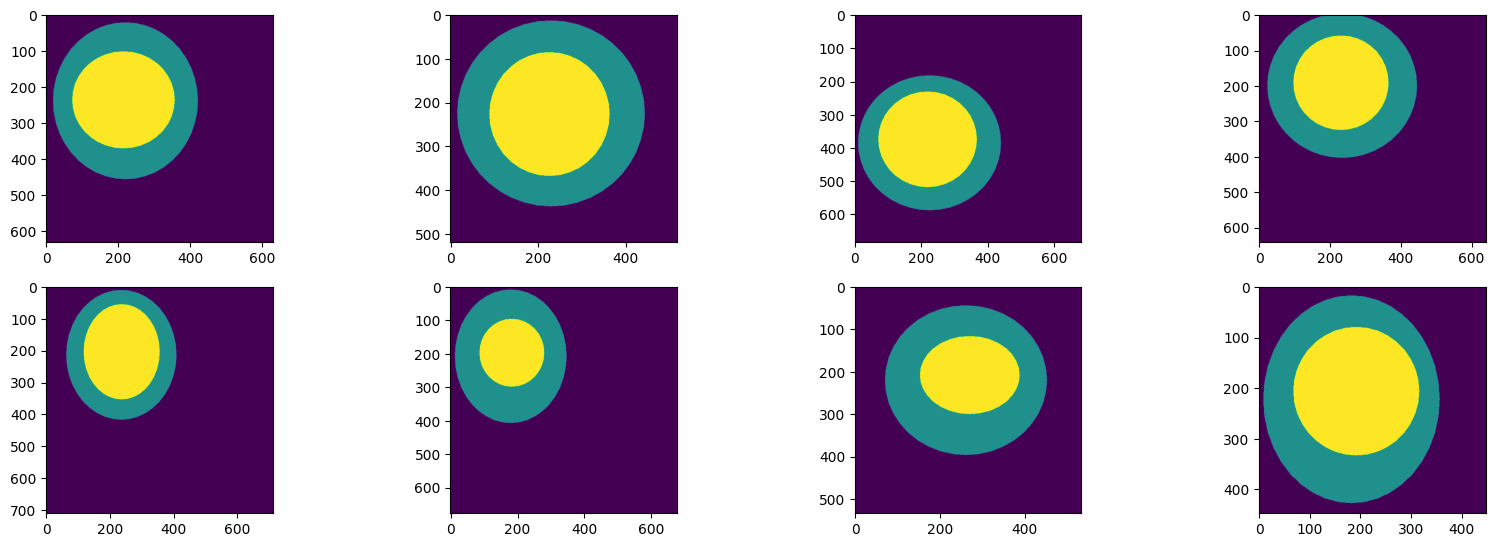

In [29]:
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(images_test_gt):
    plt.subplot(int(len(images_test_gt) / columns + 1), columns, i + 1)
    plt.imshow(loadmat(image).get('mask'))

In [30]:
# #--------------------!!!!!!!!--------------------
# plt.figure(figsize=(20,10))
# columns = 4
# for i, image in enumerate(images_test_result_disk):
#     plt.subplot(int(len(images_test_result_disk) / columns + 1), columns, i + 1)
#     img = loadmat(image).get('mask')
#     plt.imshow(img)

In [31]:
# #--------------------!!!!!!!!--------------------
# plt.figure(figsize=(20,10))
# columns = 4
# for i, image in enumerate(images_test_result_cup):
#     plt.subplot(int(len(images_test_result_cup) / columns + 1), columns, i + 1)
#     img = loadmat(image).get('mask')
#     plt.imshow(img)

In [32]:
# #--------------------!!!!!!!!--------------------
# device = 'cpu'
# torch.set_default_device(device)

# threshold = 0.8
# plt.figure(figsize=(20,10))
# columns = 4
# for i, image in enumerate(images_test_result_disk):
#     plt.subplot(int(len(images_test_result_disk) / columns + 1), columns, i + 1)
    
#     img = loadmat(image).get('mask')
#     img = (img-np.min(img))/(np.max(img)-np.min(img))
#     img =  torch.from_numpy(img)
#     #print (img)
#     img = img.numpy()
#     binary_mask = np.where(img > threshold, 1, 0)
#     # unique_values, counts = np.unique(binary_mask, return_counts=True)
#     # for value, count in zip(unique_values, counts):
#     #     print(str(value) +":    "+str(count))
    
#     #smoothed_image = cv2.GaussianBlur(binary_mask.astype(np.float32), (0, 0), sigmaX=2, sigmaY=2)
#     # Convert the result back to binary (threshold)
#     #binary_mask = cv2.threshold(smoothed_image, 0.5, 1, cv2.THRESH_BINARY)[1]
#     plt.imshow(binary_mask)
#     #break
#     #plt.show()

In [33]:
# #--------------------!!!!!!!!--------------------
# device = 'cpu'
# torch.set_default_device(device)

# threshold = 0.6
# plt.figure(figsize=(20,10))
# columns = 4
# for i, image in enumerate(images_test_result_cup):
#     plt.subplot(int(len(images_test_result_cup) / columns + 1), columns, i + 1)
    
#     img = loadmat(image).get('mask')
#     img = (img-np.min(img))/(np.max(img)-np.min(img))
#     img =  torch.from_numpy(img)
#     img = img.numpy()
    
#     binary_mask = np.where(img > threshold, 1, 0)
#     # unique_values, counts = np.unique(binary_mask, return_counts=True)
#     # for value, count in zip(unique_values, counts):
#     #     print(str(value) +":    "+str(count))
#     #print(binary_mask)
#     #break
#     #smoothed_image = cv2.GaussianBlur(binary_mask.astype(np.float32), (0, 0), sigmaX=5, sigmaY=5)
#     # Convert the result back to binary (threshold)
#     #binary_mask = cv2.threshold(smoothed_image, 0.5, 1, cv2.THRESH_BINARY)[1]
#     plt.imshow(binary_mask)
#     #plt.show()

In [34]:
unique_values, counts = np.unique(binary_mask, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

NameError: name 'binary_mask' is not defined

In [ ]:
threshold = 0.5
model_disk.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        
        #cropped_image = crop_image(np.array(Image.open(image)), 20, 40)
        #image = Image.fromarray(cropped_image)
        image = Image.open(image)
        image = image.resize((512, 512), resample=Image.NEAREST)
        image = image.convert('L')
        image = transform(image)
        image = image.unsqueeze(0)
        
        image = image.to(device) 
        output = model_disk(image)

        output = output.detach().cpu().numpy()[0]

        output = (output[0, :, :] > threshold)
    
        # output = torch.stack(output).sum(dim=1) > 0
        # output = output.detach().cpu().numpy()[0]
        
        plt.imshow(output)
        print(output.shape)
        break
        #output_dict = {"mask": output}
        # savemat(test_results_disk_folder + "\/" + filename.strip(".jpg") + ".mat", output_dict)

In [ ]:
num = 615
img = cv2.imread(images_test[0])
result = output
gt = loadmat(images_test_gt[0]).get('mask')
gt[gt == 2] = 1
gt[gt == 1] = 255
plt.figure(figsize=(20,200))
plt.subplot(1,3,1)
plt.imshow(result)
plt.subplot(1,3,2)
plt.imshow(gt)
plt.subplot(1,3,3)
plt.imshow(img)

In [ ]:
threshold = 0.5
model_cup.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        image = Image.open(image)
        image = image.resize((512, 512), resample=Image.NEAREST)
        image = image.convert('L')
        image = transform(image)
        image = image.unsqueeze(0)
        
        image = image.to(device) 
        output = model_cup(image)

        output = output.detach().cpu().numpy()[0]
        output = (output[0, :, :] > threshold)
    
        # output = torch.stack(output).sum(dim=1) > 0
        # output = output.detach().cpu().numpy()[0]
        
        plt.imshow(output)
        print(output.shape)
        break
        
        # output_dict = {"mask": output}
        # savemat(test_results_cup_folder + "\/" + filename.strip(".jpg") + ".mat", output_dict)